# Exploratory work on Siamese convolutional networks for miniproject 1

### What is a siamese network?
A network that has two identical datapaths through weight sharing.

### Importing libs

In [1]:
import torch
from torch import nn as nn
from torch import functional as F
from matplotlib import pyplot as plt
import pandas as pd
import DL_project_utils as utils
from ray import tune
from ray.tune.schedulers import ASHAScheduler


%load_ext autoreload
%autoreload 1
%aimport DL_project_utils

C:\ProgramData\Anaconda3\envs\DeepLearning\lib\site-packages\ray\autoscaler\_private\cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


### Defining the model

In [182]:
class SiameseNet1(nn.Module):
    def __init__(self, auxiliary_loss=False, auxiliary_weight=0.4):
        super().__init__()
        self.shared_model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), padding=(2,2)),
            nn.Dropout2d(p=0.5),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=(1,1)),
            nn.Dropout2d(p=0.4),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Flatten(),
            nn.Linear(in_features=576, out_features=256),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=10),
            nn.ReLU()
        )
        self.comparator = nn.Sequential(
            nn.Linear(in_features=20, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=2)
        )
        self.auxiliary_loss = auxiliary_loss
        self.auxiliary_weight = auxiliary_weight


    def forward(self, x):
        num_1 = x[:,0,:,:].unsqueeze(1)
        num_2 = x[:,1,:,:].unsqueeze(1)

        pred_1 = self.shared_model(num_1)
        pred_2 = self.shared_model(num_2)
        if self.auxiliary_loss:
            classes = torch.cat([pred_1.view(-1,10,1), pred_2.view(-1,10,1)], dim=2)
            return self.comparator(torch.cat((pred_1, pred_2), 1)),  classes
        else:
            return self.comparator(torch.cat((pred_1, pred_2), 1))

In [183]:
class SiameseNet2(nn.Module):
    def __init__(self, auxiliary_loss=False, auxiliary_weight=0.4):
        super().__init__()
        self.shared_model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), padding=(2,2)),
            nn.Dropout2d(p=0.5),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=(1,1)),
            nn.Dropout2d(p=0.4),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Flatten(),
            nn.Linear(in_features=576, out_features=256),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10),
            nn.ReLU()
        )
        self.comparator = nn.Sequential(
            nn.Linear(in_features=20, out_features=2),
            nn.ReLU()
        )
        self.auxiliary_loss = auxiliary_loss
        self.auxiliary_weight = auxiliary_weight

    def forward(self, x):
        num_1 = x[:,0,:,:].unsqueeze(1)
        num_2 = x[:,1,:,:].unsqueeze(1)

        pred_1 = self.shared_model(num_1)
        pred_2 = self.shared_model(num_2)
        if self.auxiliary_loss:
            classes = torch.cat([pred_1.view(-1,10,1), pred_2.view(-1,10,1)], dim=2)
            return self.comparator(torch.cat((pred_1, pred_2), 1)),  classes
        else:
            return self.comparator(torch.cat((pred_1, pred_2), 1))

### Training and plotting performance

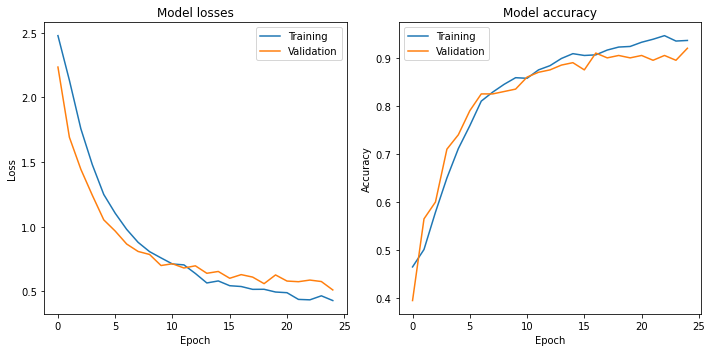

The test data gives an accuracy of 92.4000%


In [189]:
train_data, test_data = utils.read_input(pairs=1000)

epochs, lr, loss, optimizer, batch_size = 25, 2e-3, 'cross_entropy', 'Adam', 100
model = SiameseNet1(auxiliary_loss=True, auxiliary_weight=0.4)
train_loss, train_acc, val_loss, val_acc = utils.train_model(model, train_dataset=train_data, batch_size=batch_size, learning_rate=lr,
                                                             optimizer=optimizer, loss=loss, epochs=epochs,
                                                             verbose=False, cuda=True)

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model losses')
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

print(f'The test data gives an accuracy of {100*utils.evaluate_model(model, test_data, True, 500):.4f}%')

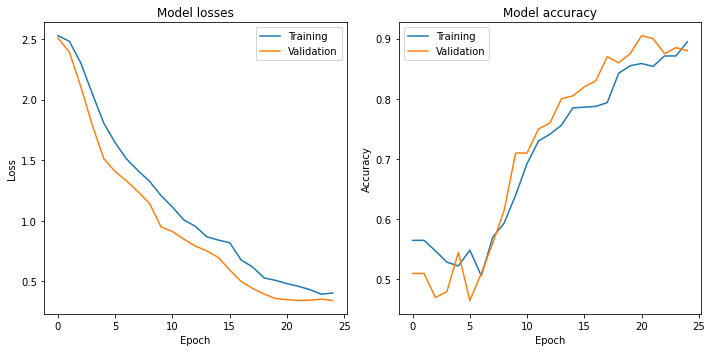

The test data gives an accuracy of 87.1000%


In [181]:
train_data, test_data = utils.read_input(pairs=1000)

epochs, lr, loss, optimizer, batch_size = 25, 2e-3, 'cross_entropy', 'Adam', 100
model = SiameseNet2(auxiliary_loss=True, auxiliary_weight=0.4)
train_loss, train_acc, val_loss, val_acc = utils.train_model(model, train_dataset=train_data, batch_size=batch_size, learning_rate=lr,
                                                             optimizer=optimizer, loss=loss, epochs=epochs,
                                                             verbose=False, cuda=True)

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model losses')
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

print(f'The test data gives an accuracy of {100*utils.evaluate_model(model, test_data, True, 500):.4f}%')

# Hyperparameter tuning

In [ ]:
def gen_siamese_net(model_type, conv_dropout, fc_dropout, hidden_units):

In [41]:
from ray import tune

digraph{
  1 [shape=record,style=filled, fillcolor="#f0f0f0",label="{ SiameseNet1 }"]
}
